In [3]:
import segmentation_models_pytorch as smp
import torch
from torch import nn

In [4]:
import sys
import os

In [5]:
import rasterio
import numpy as np

In [6]:
import matplotlib.pyplot as plt
import scipy.ndimage as nd

# Модель

In [7]:
sys.path.append(os.path.abspath(os.path.join('..')))
from utils.utils import tiff_to_tensor, plot_channels
from unet_pipeline.model_unet import create_unet_with_10_channels, load_unet_model
sys.path.pop()
sys.path.append(os.path.abspath(os.getcwd()))

In [8]:
# Создаем модель UNet с 10 входными каналами
model = create_unet_with_10_channels()
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [59]:
model = load_unet_model('best_model_dice_1.pth')

In [60]:
def get_crops(image, size, intersection_rate=0.2):
    h, w = image.shape[1:3]
    step = int((1 - intersection_rate) * size)
    print(image.shape)
    crops = []
    
    for x1 in range(0, w, step):
        if x1 + size > w:
            x1 = w - size
        for y1 in range(0, h, step):
            if y1 + size > h:
                y1 = h - size
            i = image[...,y1:y1 + size, x1:x1 + size]
            crops.append(i)
    
    return crops

In [61]:
import numpy as np

def assemble_from_crops(crops, original_size, crop_size, intersection_rate=0.2):
    h, w = original_size
    step = int((1 - intersection_rate) * crop_size)
    
    # Инициализация пустых массивов для итогового изображения и маски
    assembled_image = torch.zeros((crops[0].shape[0], h, w), dtype=crops[0].dtype)
    count_map = torch.zeros((1, h, w), dtype=torch.int32)  # Карта для учета перекрытий
    
    idx = 0
    for x1 in range(0, w, step):
        if x1 + crop_size > w:
            x1 = w - crop_size
        for y1 in range(0, h, step):
            if y1 + crop_size > h:
                y1 = h - crop_size
            
            # Добавляем текущий кроп к итоговому изображению и маске
            assembled_image[..., y1:y1 + crop_size, x1:x1 + crop_size] += crops[idx]
            count_map[..., y1:y1 + crop_size, x1:x1 + crop_size] += 1
            idx += 1
    
    # Усреднение для областей с перекрытием
    assembled_image /= torch.maximum(count_map, torch.tensor(1, dtype=count_map.dtype))
    
    return assembled_image

In [98]:
t = tiff_to_tensor('8.tif')

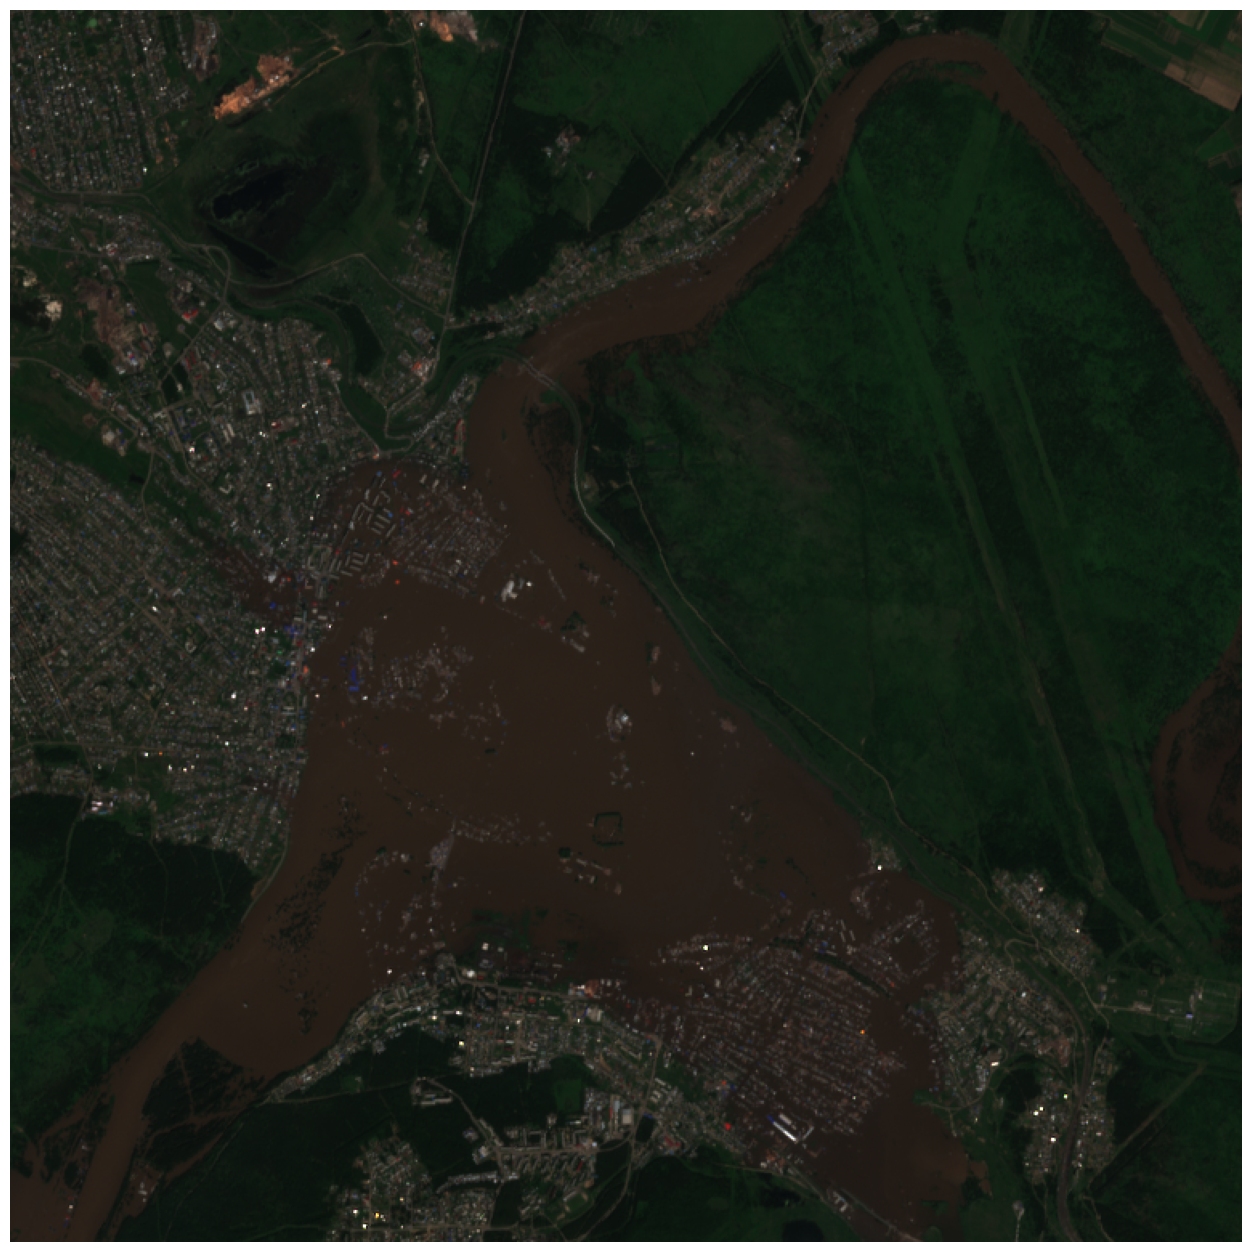

In [99]:
plot_channels(t)

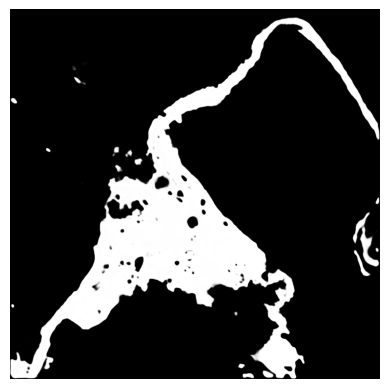

In [100]:
p = model (t.cuda().unsqueeze(0))
# Переносим тензор на CPU и удаляем лишние измерения
p_image = p.squeeze(0).cpu().detach().numpy()

# Если это изображение из одного канала (ч/б)
if p_image.shape[0] == 1:
    p_image = p_image[0]  # Убираем размерность канала для отображения

# Отрисовка изображения
plt.imshow(p_image, cmap='gray')
plt.axis('off')
plt.show()

In [101]:
def save_binary_mask(m0, output_path, threshold=0.5):
    # Шаг 1: Преобразование в бинарную маску
    mask = (m0.detach() > threshold).to(torch.uint8)  # Преобразуем к uint8 для бинарной маски (0 и 1)
    
    # Шаг 2: Преобразование тензора в numpy-массив
    mask_np = mask.squeeze().cpu().numpy()  # Перемещаем на CPU, если нужно, и преобразуем в numpy
    print(mask_np.shape)
    # Шаг 3: Сохранение в формате TIFF
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=mask_np.shape[0],
        width=mask_np.shape[1],
        count=1,  # одна полоса для маски
        dtype=mask_np.dtype
    ) as dst:
        dst.write(mask_np, 1)

save_binary_mask(p, '8.tif', 0.3)

(768, 768)


In [102]:
def ttt(tif_path, max = 5000):
    """
    Читает все каналы из файла.
    Обрезает верхнюю границу значений пикселей.
    Нормализация по текущему изображению.
    
    Parameters:
    - tif_path: Путь до изображения.
    - max (5000): Порог яркости.
    
    Returns:
    - torch.Tensor: Обработанное изображение.
    """
    with rasterio.open(tif_path) as src:
        # Читаем все каналы изображения и преобразуем в numpy-массив
        img_array = src.read()  # Получаем массив с форматом (channels, height, width)
    img_tensor = torch.from_numpy(img_array).float()
    img_tensor = torch.clamp(img_tensor, max=max)
    img_tensor = (img_tensor - 0) / (max - 0)
    return img_tensor

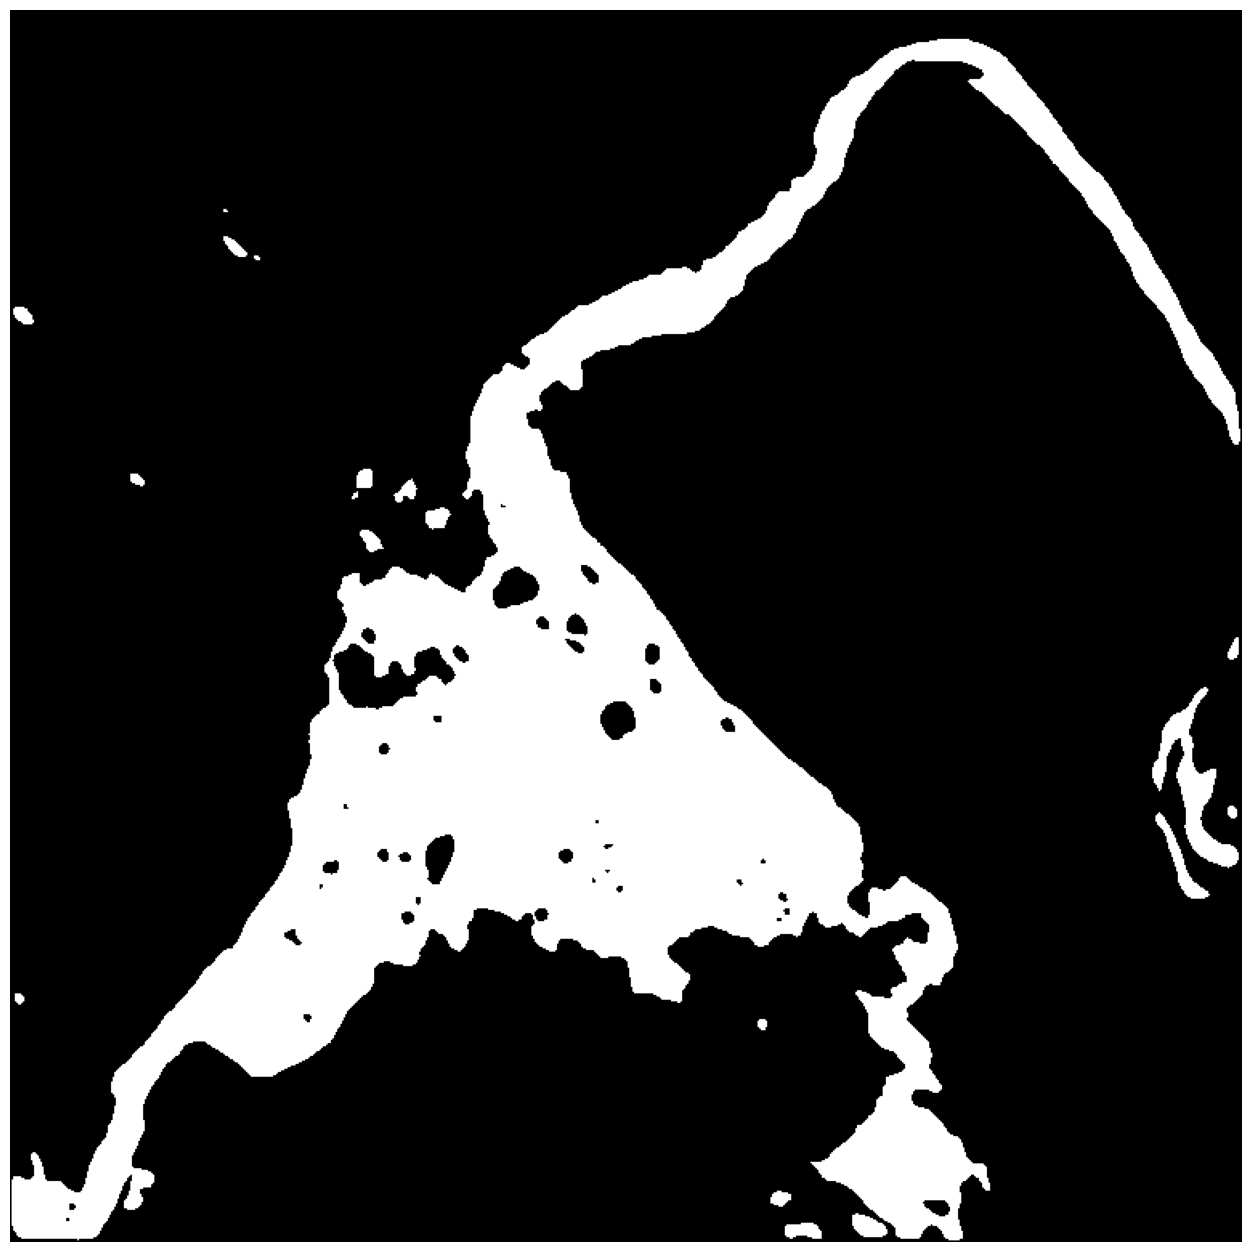

In [108]:
sv = ttt('8.tif', max=1)
plot_channels(sv, rgb=[0]*3)

In [74]:
cr = torch.stack(get_crops(t, 640,0.1))
spatial_shape = t.shape[1:]  # Извлекаем только (4956, 2560)
spatial_tuple = tuple(spatial_shape) 
print(spatial_tuple) # Преобразуем в кортеж
i = assemble_from_crops(cr, spatial_tuple, 640, 0.1)

torch.Size([10, 768, 768])
(768, 768)


In [65]:
import gc


In [66]:
# Разделяем тензор на батчи по 8 вдоль нулевой оси
batches = torch.split(cr, 8, dim=0)
preds = []
model.cuda()
# Проверим размеры каждого батча
for i, batch in enumerate(batches):
    print(f"Batch {i+1}: {batch.size()}")
    p = model(batch.cuda())
    print(p.shape)
    torch.save(p.cpu(), f"predictions_batch_{i+1}.pt")



Batch 1: torch.Size([1, 10, 128, 128])
torch.Size([1, 1, 128, 128])


In [67]:
# Получаем список всех файлов, начинающихся с "predictions_batch_"
pred_files = sorted([f for f in os.listdir('.') if f.startswith("predictions_batch_")])

# Загружаем предсказания и объединяем их в один тензор
all_preds = []
for file_name in pred_files:
    file_path = os.path.join('.', file_name)
    pred = torch.load(file_path)
    all_preds.append(pred)

C:\Users\Роман\AppData\Local\Temp\ipykernel_24476\2435958319.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred = torch.load(file_path)


In [68]:
def assemble_image(crops, image_shape, size, intersection_rate=0.2):
    h, w = image_shape[1:3]
    step = int((1 - intersection_rate) * size)
    
    # Создаем пустое изображение и счётчик наложений
    assembled_image = torch.zeros(image_shape, dtype=crops[0].dtype)
    overlap_counter = torch.zeros((image_shape[1], image_shape[2]), dtype=torch.int32)
    
    crop_idx = 0
    for x1 in range(0, w, step):
        # Корректируем положение кропа на краю изображения
        if x1 + size > w:
            x1 = w - size
        for y1 in range(0, h, step):
            if y1 + size > h:
                y1 = h - size

            # Добавляем кроп и увеличиваем счётчик наложений
            assembled_image[..., y1:y1 + size, x1:x1 + size] += crops[crop_idx]
            overlap_counter[y1:y1 + size, x1:x1 + size] += 1
            crop_idx += 1

    # Нормализуем результат с учетом наложений
    overlap_counter = overlap_counter.clamp(min=1)  # Избегаем деления на ноль
    assembled_image = assembled_image / overlap_counter

    return assembled_image

In [19]:

all_preds_tensor = torch.cat(all_preds, dim=0)
all_preds_tensor.shape
size = spatial_tuple
m0 = assemble_from_crops(all_preds_tensor, size, 640, 0.1)

torch.Size([1, 4956, 2560])


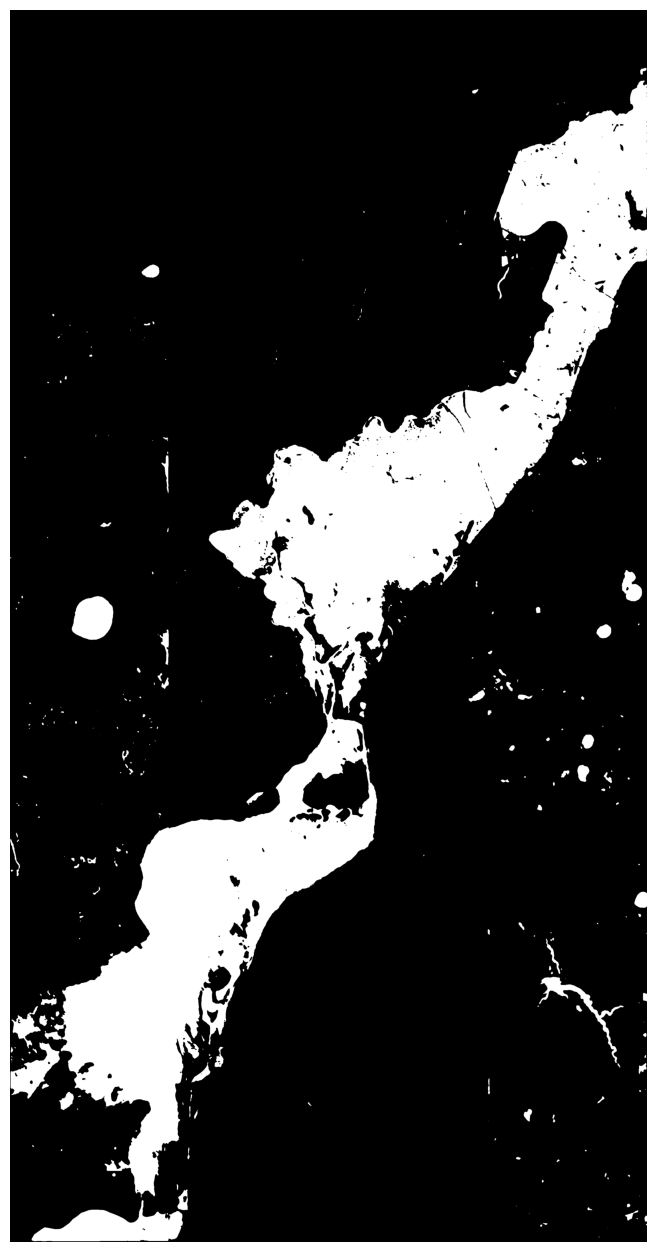

In [69]:
print(m0.shape)
mask = 255 * (m0.detach() > 0.3).to(torch.uint8)
plot_channels(mask, rgb=[0]*3)

In [21]:
def save_binary_mask(m0, output_path, threshold=0.5):
    # Шаг 1: Преобразование в бинарную маску
    mask = (m0.detach() > threshold).to(torch.uint8)  # Преобразуем к uint8 для бинарной маски (0 и 1)
    
    # Шаг 2: Преобразование тензора в numpy-массив
    mask_np = mask.squeeze().cpu().numpy()  # Перемещаем на CPU, если нужно, и преобразуем в numpy
    print(mask_np.shape)
    # Шаг 3: Сохранение в формате TIFF
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=mask_np.shape[0],
        width=mask_np.shape[1],
        count=1,  # одна полоса для маски
        dtype=mask_np.dtype
    ) as dst:
        dst.write(mask_np, 1)

# Пример использования
output_path = "2.tif"
save_binary_mask(m0, output_path)

(4956, 2560)


c:\Anaconda\envs\pip-torch\Lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


c:\Anaconda\envs\pip-torch\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


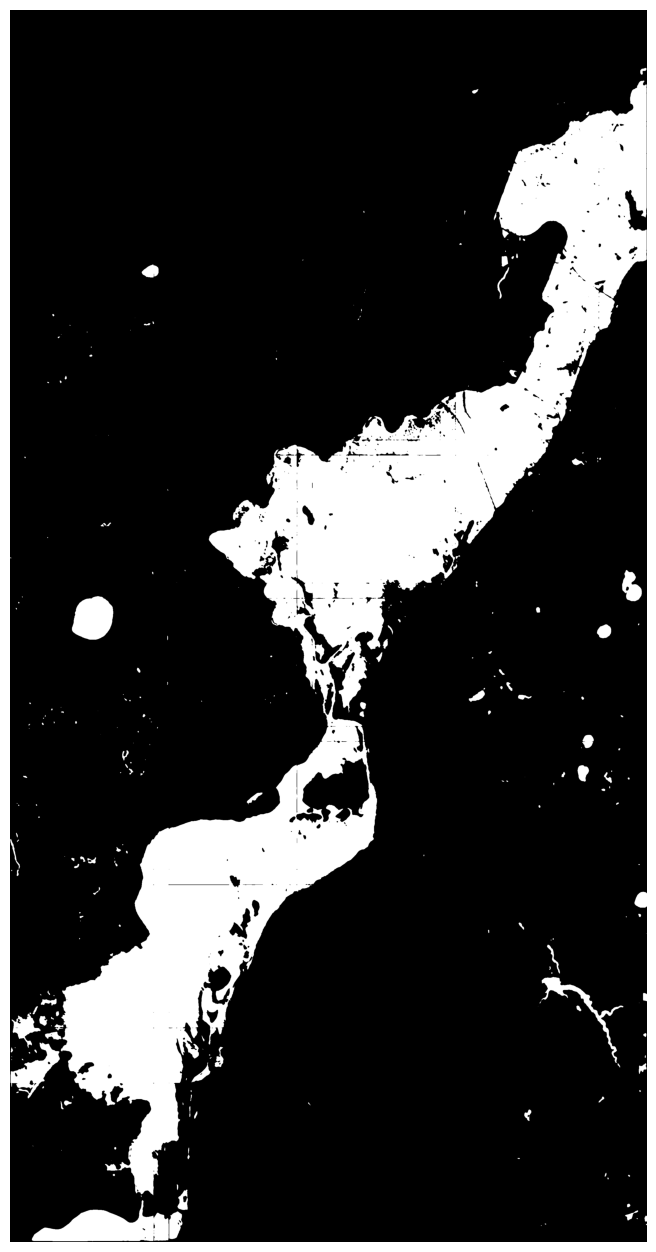

In [23]:
test = ttt('2.tif', max=1)
plot_channels(test, rgb=[0]*3)